**CS985_Assignment2_Part2**

Notebook link: 
https://colab.research.google.com/drive/1C702j_bKk3GqArshQ4HEengR9JLkw7ew?usp=sharing 

# Overview and Abstract

**Team J**




This was a multi classification problem aiming to predict the the category type of German contracts. The nature of the data is a combination of numerical values and text, with the majority of it being text. To deal with the different nature of the data we have used a conbination of encoding techniques as well as   natural language processing for feature extraction within the different words within dense representations.

Initially , we report a random forest using a matrix of token counts, for each text feaure. This is our baseline performance, which also got the best performance of about 49% F1 score.

We then build a base dense deep learning model which was able to achieve a 45% F1 score, fairly expectedly close our baseline.

We then introduce text Vectorization and a combination of Recurrent Neural Networks.
We observe that GRU RNN with a single word embedding layer, is able to provide very good performance of 31% F1 score.

We then expermient with a variation of that model using LSTM layers, however we observe that the model performance goes down significantly to 16% F1 score.

Finally we go on to explore employing 1D Convolutional layers, which would work as an attention mechanism which can focus on more important information from the input signal based on the ["A Multi-scale Convolutional Attention Based GRU Network for Text Classification" paper](https://ieeexplore.ieee.org/document/8996433). This was also our best performing RNN model which was able to combine both CNN and Gated Recurrent Units (GRUs), getting a score of 34% F1 score.

# Method

In [ ]:
!pip install scikit-learn==0.21.2

     |████████████████████████████████| 6.7MB 9.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from google.colab import files
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving german-contracts-test.csv to german-contracts-test.csv
Saving german-contracts-train.csv to german-contracts-train.csv


In [ ]:
df = pd.read_csv('german-contracts-train.csv')
test = pd.read_csv('german-contracts-test.csv')

## Data Preprocessing and Feature Extraction

Generally the project focused for the most part on the three text columns (description, awarding authority and title). Where three different methods were used for encoding it.

The base machine learning model uses the CountVectorizer which is a scikit learn provided function for processing text. It outputs the text as a sparse matrix which is how the data was passed to the model.

The dense deep learning model uses the text vectorizer method which comes with keras. It was used to again process the text and return it as a matrix, however the number of tokens had to be capped, because of memory issues.

The rest of the neural network models preprocess text using the text vectorization layer, and can directly preprocess the input received. That is then fed into an embedding layer which is ultimately how the data is used. It is overall much more memory efficient, which is why it was also prefrred for the RNN models. Additionally for better memory efficiency the three text columns were merged which did not seem to lower the performance of the RNNs as opposed to having three separate embedding layers.

## Base Machine Leraning Model

For the base machine learning model we used a **Random Forest Classifier** from scikit learn, where we encoded all text features individually using the CountVectorizer class as provided by scikit learn, and with minimal parameter tuning, namely we only limited the max_depth of the Random Forest. It gave us a very good baseline for what to expect from the neural nets that we were about to build.

As a note here, we initially tried a Multinomial Naive Bayes Classifier, which is usually employed for text classification problems, however its performance was too low (about 0.05), perhaps because it needed better paramter tuning or maybe the mixture of the different types of encoded data, which is why we switched to the Random Forest classifier as our baseline model.

## Base Dense Deep Learning Model

For the base deep learning model, we mostly focused on the text features of the dataset. Where the general model architecture was kept fairly simple and the number of layers, neurons and type of activation function was optimized by exploring the different options.
Overall the best performing model was the one with two Dense layer using a RELU activation function.

In [ ]:
class BaseNN(keras.Model):
  def __init__(self, units=300, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = keras.layers.Dense(units, activation=activation)
    self.hidden2 = keras.layers.Dense(units, activation=activation)
    self.main_output = keras.layers.Dense(176, activation='softmax')

  def call(self, inputs):
    hidden1 = self.hidden1(inputs)
    hidden2 = self.hidden2(hidden1)
    main_output = self.main_output(hidden2)
    return main_output

## Neural Network 1, GRU RNN with a single embedding layer

The architecture of this network was based on the one defined in the "Efficient Processing of GRU Based on Word Embedding for Text Classification" paper.
It is a Recurrent Neural Network that uses a single embedding layer, followed by multiple GRU layers and finally the output of those is fed to a softmax classification layer. The main reason for using this architecture was because of the large amount of text data available a more efficient architecture was needed in order to be able create and train the deep learning model.

In [ ]:
def GRU_RNN(neurons = 200, dropout=0.5, learning_rate=0.001):
  # There are a lot of unique tokens (180 883), the max_tokens is slightly larger in case there are some new ones in the test set
  descr = keras.layers.experimental.preprocessing.TextVectorization(output_mode='int', max_tokens=180890)
  descr.adapt(all_text.values)
  descr_size = len(descr.get_vocabulary()) 
  # Text processing layers
  description_input = keras.layers.Input(shape=[], dtype=tf.string)
  description_layer = descr(description_input)
  single_embedding = keras.layers.Embedding(input_dim=descr_size, output_dim=16, mask_zero=True)(description_layer)

  l1 = keras.layers.GRU(neurons, return_sequences=True, dropout=dropout)(single_embedding)
  l2 = keras.layers.GRU(neurons, return_sequences=True, dropout=dropout)(l1)
  l3 = keras.layers.GRU(neurons, dropout=dropout)(l2)

  # Combine the two and classify
  outputs = keras.layers.Dense(176, activation='softmax')(l3)
  model = keras.models.Model(inputs=[description_input],outputs=[outputs])
  model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
  return model

## Neural Network 2, LSTM
This model is based off of the structure proposed in "Long Short-Term Memory" by Hochreiter and Schmidhuber. Like the previous two models, this is a Reccurent Neural Network. Although RNNs are able to recall information from previous states, this information becomes degraded and diluted over time and so the model may struggle to recall information after significant gaps, which can be a serious problem in text analysis. Unlike these other models, the LSTM model adopts a more complex structure which allows it to selectively store, read and erase long term memory that is passed to successors.

Generally we tried to make it as a variation of the previous model, with the only difference that we had to fine tune it ourselves.

In [ ]:
def LSTM_model(text):
  descr = keras.layers.experimental.preprocessing.TextVectorization(output_mode='int', max_tokens=180890)
  descr.adapt(text)
  descr_size = len(descr.get_vocabulary()) 

  description_input = keras.layers.Input(shape=[], dtype=tf.string)
  description_layer = descr(description_input)
  single_embedding = keras.layers.Embedding(input_dim=descr_size, output_dim=16, mask_zero=True)(description_layer)

  lstm1 = tf.keras.layers.LSTM(300, return_sequences=True, dropout=0.5)(single_embedding)
  lstm2 = tf.keras.layers.LSTM(300, return_sequences=True, dropout=0.5)(lstm1)
  lstm3 = tf.keras.layers.LSTM(300, dropout=0.5)(lstm2)

  outputs = keras.layers.Dense(176, activation='softmax')(lstm3)
  model = keras.models.Model(inputs=[description_input],outputs=[outputs])
  model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
  return model

## Neural Network 3, GRU RNN with 1D convolutional layers

This model follows the architecture proposed in the "A Multi-scale Convolutional Attention Based GRU Network for Text Classification" paper. Much like the previous one it is a Recurrent Neural Network that utilizes an embedding layer and multiple GRU layers, however it also uses 1D Convolutional layers, which can be used as attention mechanisms, that help focus on more important parts of the signal. The two parts of the mode, namely the GRU layers and the convolutional layers are multiplied together and fed into a global max pooling layer which is connected to the final classification layer.

In [ ]:
def GRU_CNN_model(text):
  descr = keras.layers.experimental.preprocessing.TextVectorization(output_mode='int', max_tokens=180890)
  descr.adapt(text)
  descr_size = len(descr.get_vocabulary()) 

  description_input = keras.layers.Input(shape=[], dtype=tf.string)
  description_layer = descr(description_input)
  global_embedding = keras.layers.Embedding(input_dim=descr_size, output_dim=16, mask_zero=True)(description_layer)

  l1 = keras.layers.GRU(300, return_sequences=True, dropout=0.5)(global_embedding)
  l2 = keras.layers.GRU(300, return_sequences=True, dropout=0.5)(l1)
  l3 = keras.layers.GRU(300, dropout=0.5)(l2)

  l1c = keras.layers.Convolution1D(filters=300, kernel_size=3, padding='same', activation='relu')(global_embedding)
  l2c = keras.layers.Convolution1D(filters=300, kernel_size=3, padding='same', activation='relu')(l1c)
  l3c = keras.layers.Convolution1D(filters=300, kernel_size=3, padding='same', activation='relu')(l2c)

  concat = keras.layers.Multiply()([l3c, l3])
  d1 = keras.layers.GlobalMaxPool1D()(concat)
  outputs = keras.layers.Dense(176, activation='softmax')(d1)
  model = keras.models.Model(inputs=[description_input],outputs=[outputs])
  model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
  return model

## Training Schedule Approach

Generally in order to find the best parameters to use for each model we used Grid Search. It was particularly useful for the base neural network and the GRU single embedding neural network (the first one of the additional models implemented). In order to use grid search, model building functions were defined in such a way that allowed the number of layers, neurons and drop out rates to be set through the function's input parameters.

For the Dense Deep Learning model, we used a GridSearchCV, with a custom defined function and a small range of parameters, due to how time consuming it can be, especially if when training it for a large number of epochs.

For Neural Network 1 (the GRU only RNN), we mostly relied on the parameters specified in the paper that we followed. We explored some different options with regards to changing the number of neurons, layers but for the most part those did not perfrom as well. It was particularly difficult to try out many different configurations primarirly due to the limited GPU resources on Google Colab.

As previously mentioned for Neural Network 2 , where we created a custsom function that would allow us to find the best parameters either through GridSearchCV or RandomizedSearchCV. Those were very time consuming however, because GPU time on Google Colab is very limited and thus the notebook would often get disconnected. This is why the search space was fairly small.

For Neural Network 3 (the RNN + CNN variant), because we based it directly of the algorithm given in the paper, we stuck to the parameters used by them.

In [ ]:
# Based on the functions used in the lab
def Base_NN_model(n_hidden=2, n_neurons=300, learning_rate=3e-3, activation = 'relu'):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=[1500]))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation=activation))
  model.add(keras.layers.Dense(176, activation="softmax"))
  model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
  return model

In [ ]:
def LSTM_test_model(lstm_neurons = 300, n_lstm_layers=2, dropout=0.5, learning_rate=0.001):
  # There are a lot of unique tokens (180 883), the max_tokens is slightly larger in case there are some new ones in the test set
  descr = keras.layers.experimental.preprocessing.TextVectorization(output_mode='int', max_tokens=180890)
  descr.adapt(all_text.values)
  descr_size = len(descr.get_vocabulary()) 
  # Text processing layers
  description_input = keras.layers.Input(shape=[], dtype=tf.string)
  description_layer = descr(description_input)
  single_embedding = keras.layers.Embedding(input_dim=descr_size, output_dim=16, mask_zero=True)(description_layer)
  lstm_layers = []
  for i in range(n_lstm_layers):
    if i == 0:
      lstm_layers.append(keras.layers.LSTM(lstm_neurons, dropout=dropout, return_sequences=True)(single_embedding))
    else:
      lstm_layers.append(keras.layers.LSTM(lstm_neurons, dropout=dropout, return_sequences=True)(lstm_layers[i-1]))
  end_lstm = keras.layers.LSTM(lstm_neurons, dropout=dropout)(lstm_layers[n_lstm_layers-1])

  # Combine the two and classify
  outputs = keras.layers.Dense(176, activation='softmax')(end_lstm)

  model = keras.models.Model(inputs=[description_input],outputs=[outputs])
  model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
  return model

## Other Approaches

Some experimentation was done using all encoded variables together with the word embedding however those extra variables did not seem to increase the F1 score or the accuracy, but only made the model training slower, which is why that approach was dropped. Additionally, when only using a dense model with the contract type and nature of contract variables the performance was incredibly low, which could be a good indicator of the predictive power of those variables, so overall our expectations were that the models should not suffer if we were to drop them from the training/test sets.

# Results and Discussion

**Parameters setttings for each approarch:**

Random Forrest Classifier model:
*   max_depth=300

Paramteres for the Base Dense Deep Learning Network:
*   Adam optimization with 0.001 learning rate
*   Hidden Dense Layers = 2
*   Dense Layer Neurons = 300
*   Activation = ReLU

The parameters used for Neural Network 1 were:
*   Adam optimization with 0.001 learning rate
*   GRU Layers = 3
*   GRU hidden state neurons = 200
*   Dropout rate = 0.5

The parameters used for Neural Network 2 were:
*   Adam optimization with 0.001 learning rate
*   LSTM Layers = 3
*   LSTM hidden state neurons = 300
*   Dropout rate = 0.5

The parameters used for Neural Network 3 were:
*   Adam optimization with 0.001 learning rate
*   N convolutional filters = 300
*   Convolutional filter size = 3
*   GRU hidden state neurons = 300
*   Dropout rate = 0.5

---

**Model Results**


In [ ]:
d = {'Model': ["Random Forest", "Dense NN", "NN1 | GRU RNN", "NN2 | LTSM RNN", "NN3 | GRU + CNN"], 'Training F1 Score': [0.98, 0.91, 0.75, 0.24, 0.88], 'Test F1 Score': [0.49, 0.45, 0.31, 0.16, 0.35], 'Kaggle Score': [0.93, 0.914, 0.90363, 0.89188, 0.90886]}
df = pd.DataFrame(data=d)
df

,Model,Training F1 Score,Test F1 Score,Kaggle Score
0,Random Forest,0.98,0.49,0.93000
1,Dense NN,0.91,0.45,0.91400
2,NN1 | GRU RNN,0.75,0.31,0.90363
3,NN2 | LTSM RNN,0.24,0.16,0.89188
4,NN3 | GRU + CNN,0.88,0.35,0.90886


As can be seen from the table above, overall the best performances were observed by the Random Forest and the dense neural network being a close second. More interestingly they also were trained on similarly processed data, where each text column was encoded separately in a matrix.

As opposed to them the Reccurrent Neural Networks performed considerably worse, although they were the least likely to cause memory crashes, because of their use of word embeddings which made them use much less RAM overall. The LSTM model overall was less effective compared to the GRU model, although there is no clear reason as to why, given how similar are the two models.

Of the three RNN models, the one that showed the most promise was the last one, which used both GRU and Convolutional layers. This is most likely due to the use of 1D convolutions that appear to have been able to better filter out the parts of the signal that are more important to the model. Some additional expermination might be needed here, where with different feaure encoding, which could be able to boost its performance, to something closer to the dense neural network.

Overall with regards to the Kaggle score it is hard to infer which model truly performed the best, especially since the scores are based on accuracy rather than on the F1 measure which is not necesseraly a good representation of the models' classification performance.

# Summary and Recommendation



From the models we explored and based on their relative performances and training speeds, with all things considered the Dense Neural Network, might be the best choice for a model. It was overall much quicker to train than a Random Forest and performed better than the more memory efficient RNN models, providing a good balance between training speed and performance.

Additionally it might be worth more exploring the use of 1D convolutional layers, as they showed some potential, but different data preprocessing migth be needed.

**References:**


1.   Tang, Xianlun, et al. "A Multi-scale Convolutional Attention Based GRU Network for Text Classification." 2019 Chinese Automation Congress (CAC). IEEE, 2019.
Source: https://ieeexplore.ieee.org/document/8996433 , Accessed: 11.04.2021
2.   Zulqarnain, Muhammad, et al. "Efficient processing of GRU based on word embedding for text classification." JOIV: International Journal on Informatics Visualization 3.4 (2019): 377-383.
Souce: http://joiv.org/index.php/joiv/article/view/289/238 Accessed: 11.04.2021




# Preprocessing Code and Data Analysis

## Exploratory Analysis

In [ ]:
df.head(3)

,docid,publication_date,contract_type,nature_of_contract,country_code,country_name,sector,category,value,title,description,awarding_authority,label
0,2493527426,2020-10-14,award,services,DE,Germany,public,['Energy & Environment'],75658.0,Germany-Wilhelmshaven: Cleaning services,Unterhalts- und Glasreinigung.\n,Staatliches Baumanagement Ems-Weser,100000
1,2538215982,2020-11-16,notice,services,DE,Germany,public,['Infrastructure & Construction'],NaN,Germany-Dresden: Engineering-design services f...,ABS Karlsruhe-Stuttgart-Nürnberg-Leipzig/Dresd...,DB Netz AG,1000
2,2204943443,2020-02-13,notice,works,DE,Germany,public,['Infrastructure & Construction'],470000.0,"Germany-Germering: Heating, ventilation and ai...",Nach Fertigstellung des ersten Bauabschnitts e...,Große Kreisstadt Germering,1000


At first instance we observe the data is mixed nature. The class column is 'Category;' that has been encoded in the 'label' column.

In [ ]:
df.shape, test.shape

((98320, 13), (24581, 11))

In [ ]:
df['label'].value_counts()

1000         54520
100000        6753
100           6171
1             5908
100000000     5505
             ...  
100010011        1
100111011        1
11010000         1
110010010        1
101011000        1
Name: label, Length: 176, dtype: int64

From counting the values per class for the label, we see that the sample is not balanced and that the classes are represented unequally. Label'1000' is over-represented in the sample which may make the model more prone to overfitting since the model wil learn to predict better this class.

In [ ]:
df.nunique()

docid                 98320
publication_date        254
contract_type             2
nature_of_contract        3
country_code              1
country_name              1
sector                    1
category                307
value                 23063
title                 32207
description           70652
awarding_authority    13191
label                   176
dtype: int64

In [ ]:
test.nunique()

docid                 24581
publication_date        250
contract_type             2
nature_of_contract        4
country_code              1
country_name              1
sector                    1
value                  6225
title                 13600
description           21365
awarding_authority     6774
dtype: int64

In [ ]:
df.drop(['category',  'country_code', 'country_name', 'sector'], inplace=True, axis=1)
df.reset_index(inplace=True, drop=True)

In [ ]:
test.drop(['country_code', 'country_name', 'sector'], inplace=True, axis=1)
df.reset_index(inplace=True, drop=True)

The columns 'country_code, country_name and sector' have one unique value and therefore no classification power. We have decided to drop them along with the label columns.

## Processing NAs

In [ ]:
df.isna().sum(), test.isna().sum()


(docid                     0
 publication_date          0
 contract_type             0
 nature_of_contract       17
 value                 63078
 title                     0
 description               0
 awarding_authority        0
 label                     0
 dtype: int64, docid                     0
 publication_date          0
 contract_type             0
 nature_of_contract        1
 value                 15825
 title                     0
 description               0
 awarding_authority        0
 dtype: int64)

In [ ]:
df['nature_of_contract'] = df['nature_of_contract'].fillna(df['nature_of_contract'].mode()[0])
test['nature_of_contract'] = test['nature_of_contract'].fillna(test['nature_of_contract'].mode()[0])

In [ ]:
df.drop(['value'], axis=1, inplace=True)
test.drop(['value'], axis=1, inplace=True)

In [ ]:
df.drop(df.tail(1).index,inplace=True)

We observe that the majority of the nas emerge from the 'value' column. We have kept this column seprately in case we need to use it and filled in the missing values with zeros.

## Visualizing word frequency

In [ ]:
def frequent_words (data_col, label_col, x):

    text = data_col.loc[label_col == 10].values
    wordcloud = WordCloud(
      width = 640,
      height = 640,
      background_color = 'black',
      stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
      figsize = (12, 8),
      facecolor = 'k',
      edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()



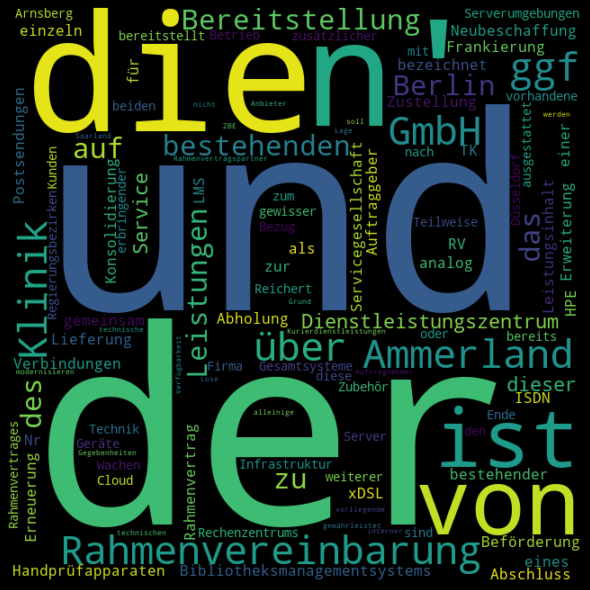

In [ ]:
frequent_words(df['description'], df['label'],10)

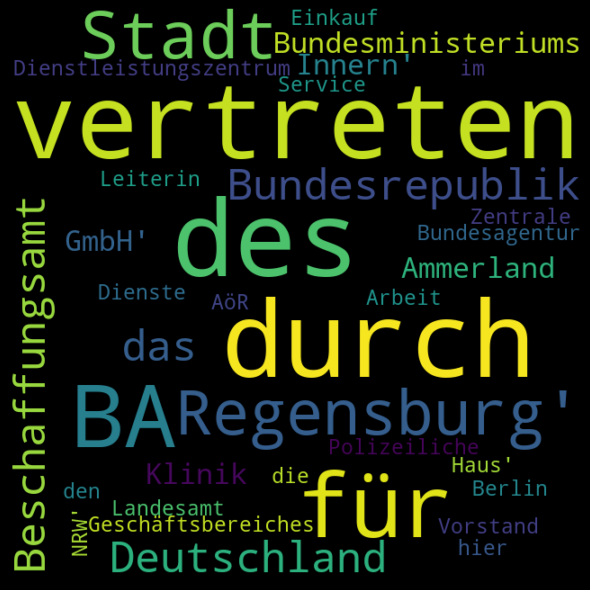

In [ ]:
frequent_words(df['awarding_authority'], df['label'],10)

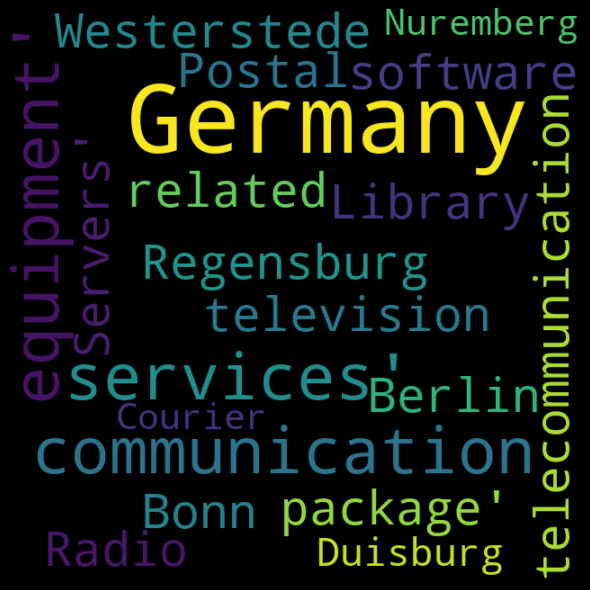

In [ ]:
frequent_words(df['title'], df['label'],10)

We have generated word clouds for the text categories in relation to the label. We took as reference label == 10 though other labels have been tried too (data not shown). The word cloud displays the most important words, as that assessed by their frequency in the text, for that particular label. From the results we  see that 'Description' is represented by far more words compared to 'Awarding authority' and 'Title'. However, 'Awarding Authority' and 'Title', have more words of high frequency (more bigger bold words), which may indicate they have better classification power.

## One-hot Encoding and Label-Encoding

In [ ]:
def one_hot_enc(train_data, test_data):
  ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
  ohe_encoder.fit(train_data)
  encoded_train_data = pd.DataFrame(ohe_encoder.transform(train_data), columns=ohe_encoder.get_feature_names())
  
  encoded_test_data = pd.DataFrame(ohe_encoder.transform(test_data), columns=ohe_encoder.get_feature_names())
  return (encoded_train_data, encoded_test_data)

In [ ]:
encoded_contract_train, encoded_contract_test = one_hot_enc(df['nature_of_contract'].to_numpy().reshape(-1,1), test['nature_of_contract'].to_numpy().reshape(-1,1))
encoded_contract_type_test = test['contract_type'].apply(lambda x: 1 if x=='notice' else 0)
encoded_contract_type_train = df['contract_type'].apply(lambda x: 1 if x=='notice' else 0)

In [ ]:
# Concat all text columns
all_text = df['description'] + " " + df['title'] + " " + df['awarding_authority']
all_text_test = test['description'] + " " + test['title'] + " " + test['awarding_authority']

**Label - Encoding the Date column**

In [ ]:
df['publication_date'] = pd.to_datetime(df['publication_date'])
month_train = df['publication_date'].dt.month
day_train = df['publication_date'].dt.day

test['publication_date'] = pd.to_datetime(test['publication_date'])
month_test = test['publication_date'].dt.month
day_test = test['publication_date'].dt.day

**Encoding the Target Column**

In [ ]:
le = LabelEncoder()
label = df['label'].apply(lambda x: str(int(x)))
le.fit(label)
encoded_label = le.transform(label)

## Function to Encode Data for the Base Machine Learning Model

In [ ]:
def encode_text(text_train, text_test):
  from sklearn.feature_extraction.text import CountVectorizer
  vectorizer = CountVectorizer()
  vectorizer.fit(text_train)
  encoded_train = vectorizer.transform(text_train)
  encoded_test = vectorizer.transform(text_test)
  return encoded_train, encoded_test

## Function to Encode Data for the Base Feed Forward Network

In [ ]:
def keras_tokenizer(text_train, text_test):
  from keras.preprocessing.text import Tokenizer
  from keras.preprocessing.sequence import pad_sequences
  tokenizer = Tokenizer(num_words=500)
  tokenizer.fit_on_texts(text_train)
  train_sequences = tokenizer.texts_to_matrix(text_train, mode='count')
  test_sequences = tokenizer.texts_to_matrix(text_test, mode='count')
  return train_sequences, test_sequences

### Submission Processing Function

In [ ]:
def generate_prediction(model, input):
  predictions_test = model.predict(input)
  class_predictions = np.argmax(predictions_test, axis=-1)
  reverse = le.inverse_transform(class_predictions)
  submission = pd.DataFrame({'docid': test['docid'].values, 'label': reverse})
  submission['label'] = submission['label'].apply(lambda x: x.zfill(9))
  submission.to_csv('test.csv', index=False)

# Run The Models

NOTE: Running the base machine learning model and the base feed forward model one after another, could cause the notebook to crash since a lot of memory is used for encoding the text, so running them individually, possibly restarting the kernel after execution, is preferred.

## Running the Base Machine Learning Model

In [ ]:
# Encode the data
description_train, description_test = encode_text(df['description'], test['description'])
title_train, title_test = encode_text(df['title'], test['title'])
awarding_authority_train, awarding_authority_test = encode_text(df['awarding_authority'], test['awarding_authority'])

In [ ]:
# Warning: Training this takes some time and might take a lot of memory (could cause a crash later, due to lack of available RAM)
from scipy import sparse as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

temp_X = sp.hstack([description_train, title_train, awarding_authority_train, encoded_contract_type_train.to_numpy().reshape(98319,1), encoded_contract_train.to_numpy()])
y = encoded_label
X_train, X_test, y_train, y_test = train_test_split(temp_X, y, test_size=0.30, random_state=42)
mnb = RandomForestClassifier(max_depth=300)
mnb.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
predictions = mnb.predict(X_train)

print('F1 Score: ', f1_score(y_train, predictions, average='macro'))
print('Accuracy Score: ', accuracy_score(y_train, predictions))

F1 Score:  0.9807092665003965
Accuracy Score:  0.9969922845560351


In [ ]:
predictions = mnb.predict(X_test)

print('F1 Score: ', f1_score(y_test, predictions, average='macro'))
print('Accuracy Score: ', accuracy_score(y_test, predictions))

F1 Score:  0.4931560271126794
Accuracy Score:  0.9235828586927041


In [ ]:
# Generate the submission csv
x_full = sp.hstack([description_test, title_test, awarding_authority_test, encoded_contract_type_test.to_numpy().reshape(-1,1), encoded_contract_test.to_numpy()])
predictions = mnb.predict(x_full)

reverse = le.inverse_transform(predictions)
submission = pd.DataFrame({'docid': test['docid'].values, 'label': reverse})
submission['label'] = submission['label'].apply(lambda x: x.zfill(9))
submission.to_csv('test.csv', index=False)

## Running the Base Feed Forward Model

In [ ]:
title_train, title_test = keras_tokenizer(df['title'], test['title'])
description_train, description_test = keras_tokenizer(df['description'], test['description'])
awarding_authority_train, awarding_authority_test = keras_tokenizer(df['awarding_authority'], test['awarding_authority'])

In [ ]:
X = np.hstack((title_train, description_train, awarding_authority_train))
y = encoded_label
X_one, X_test, y_one, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_one, y_one, test_size=0.15, random_state=42)

### Grid Search For Best Parameters

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_distribs = {
    # "n_hidden":[2, 3, 4],
    # "n_neurons": [100, 200, 300],
    # "learning_rate": [1e-2, 1e-3, 1e-4],
    "activation": ['relu', 'tanh', 'selu'],
    "epochs": [25]
}

keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_fn=Base_NN_model)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
rnd_search_cv = GridSearchCV(keras_class, param_distribs, cv=2)
# rnd_search_cv.fit(X_train, y_train, validation_data=(X_valid, y_valid), verbose=0) # Takes a lot of time (a lot) to run

In [ ]:
print(rnd_search_cv.best_params_)
# {'epochs': 25, 'learning_rate': 0.0001, 'n_hidden': 2, 'n_neurons': 300, 'activation': 'relu'}

### Scoring The Model

In [ ]:
batch_size = 32
model = Base_NN_model(learning_rate=0.0001, n_hidden=2, n_neurons=300, activation='relu')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, min_delta=0.01, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[callback]) 

Epoch 1/25
2090/2090 [==============================] - 16s 7ms/step - loss: 1.9510 - accuracy: 0.6535 - val_loss: 0.6916 - val_accuracy: 0.8551
Epoch 2/25
2090/2090 [==============================] - 14s 7ms/step - loss: 0.6434 - accuracy: 0.8627 - val_loss: 0.5653 - val_accuracy: 0.8800
Epoch 3/25
2090/2090 [==============================] - 14s 7ms/step - loss: 0.4996 - accuracy: 0.8886 - val_loss: 0.5211 - val_accuracy: 0.8875
Epoch 4/25
2090/2090 [==============================] - 14s 7ms/step - loss: 0.4481 - accuracy: 0.8968 - val_loss: 0.4939 - val_accuracy: 0.8902
Epoch 5/25
2090/2090 [==============================] - 14s 7ms/step - loss: 0.3990 - accuracy: 0.9044 - val_loss: 0.4854 - val_accuracy: 0.8902
Epoch 6/25
2090/2090 [==============================] - 14s 7ms/step - loss: 0.3572 - accuracy: 0.9122 - val_loss: 0.4660 - val_accuracy: 0.8948
Epoch 7/25
2090/2090 [==============================] - 14s 7ms/step - loss: 0.3247 - accuracy: 0.9186 - val_loss: 0.4590 - val_ac

In [ ]:
predictions=model.predict([X_train])
# Test performance
import numpy as np
class_preds = np.argmax(predictions, axis=-1)
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_train, class_preds, average='macro'))
print(accuracy_score(y_train, class_preds))

0.9133458269610973
0.9868224243149456


In [ ]:
predictions=model.predict([X_test])
# Test performance
import numpy as np
class_preds = np.argmax(predictions, axis=-1)
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_test, class_preds, average='macro'))
print(accuracy_score(y_test, class_preds))

0.4525383395015278
0.9120219690805533


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Generating The Submission CSV

In [ ]:
generate_prediction(model, np.hstack((title_test, description_test, awarding_authority_test)))

## Running Neural Network 1

In [ ]:
X = all_text
y = encoded_label
X_one, X_test, y_one, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_one, y_one, test_size=0.20, random_state=42)

### Scoring The Model

In [ ]:
model = GRU_RNN()

In [ ]:
batch_size = 64
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, min_delta=0.01, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[callback])

Epoch 1/15
861/861 [==============================] - 79s 80ms/step - loss: 1.6155 - accuracy: 0.6310 - val_loss: 0.8023 - val_accuracy: 0.8084
Epoch 2/15
861/861 [==============================] - 66s 77ms/step - loss: 0.7844 - accuracy: 0.8110 - val_loss: 0.6714 - val_accuracy: 0.8437
Epoch 3/15
861/861 [==============================] - 66s 77ms/step - loss: 0.5891 - accuracy: 0.8595 - val_loss: 0.6033 - val_accuracy: 0.8624
Epoch 4/15
861/861 [==============================] - 67s 78ms/step - loss: 0.4810 - accuracy: 0.8842 - val_loss: 0.5766 - val_accuracy: 0.8693
Epoch 5/15
861/861 [==============================] - 66s 77ms/step - loss: 0.4001 - accuracy: 0.9034 - val_loss: 0.5545 - val_accuracy: 0.8779
Epoch 6/15
861/861 [==============================] - 67s 77ms/step - loss: 0.3531 - accuracy: 0.9130 - val_loss: 0.5472 - val_accuracy: 0.8793
Epoch 7/15
861/861 [==============================] - 67s 77ms/step - loss: 0.2995 - accuracy: 0.9237 - val_loss: 0.5422 - val_accuracy:

In [ ]:
# Training Performance
predictions_train=model.predict(X_train)
train_class_preds = np.argmax(predictions_train, axis=-1)
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_train, train_class_preds, average='macro'))
print(accuracy_score(y_train, train_class_preds))

0.7520230558938776
0.9837625776453921


In [ ]:
predictions=model.predict(X_test)

In [ ]:
# Test performance
import numpy as np
class_preds = np.argmax(predictions, axis=-1)
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_test, class_preds, average='macro'))
print(accuracy_score(y_test, class_preds))

0.30781451168048835
0.9004949823704909


### Submitting the predictions

In [ ]:
generate_prediction(model, all_text_test)

## Running Neural Network 2

In [ ]:
X = all_text
y = encoded_label
X_one, X_test, y_one, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_one, y_one, test_size=0.20, random_state=42)

### Grid Searching For Best Values

**GPU is required for this part, otherwise it runs way too slow**

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_lstm_layers":[2, 3],
    "lstm_neurons": [100, 200, 300],
    "learning_rate": [1e-2, 1e-3, 1e-4],
    "epochs": [3],
}

keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_fn=LSTM_test_model)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.001, restore_best_weights=True)
rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, cv=2, n_iter=4)
rnd_search_cv.fit(X_train, y_train)

Epoch 1/3
861/861 [==============================] - 81s 80ms/step - loss: 2.5744 - accuracy: 0.5443
Epoch 2/3
861/861 [==============================] - 67s 78ms/step - loss: 1.8885 - accuracy: 0.5540
Epoch 3/3
861/861 [==============================] - 25s 24ms/step - loss: 1.3626 - accuracy: 0.6246
Epoch 1/3
861/861 [==============================] - 80s 78ms/step - loss: 2.5766 - accuracy: 0.5499
Epoch 2/3
861/861 [==============================] - 67s 78ms/step - loss: 1.9109 - accuracy: 0.5538
Epoch 3/3
861/861 [==============================] - 25s 24ms/step - loss: 1.3914 - accuracy: 0.6188
Epoch 1/3
861/861 [==============================] - 72s 72ms/step - loss: 1.9985 - accuracy: 0.5556
Epoch 2/3
861/861 [==============================] - 62s 72ms/step - loss: 1.4674 - accuracy: 0.5933
Epoch 3/3
861/861 [==============================] - 20s 20ms/step - loss: 1.0227 - accuracy: 0.7409
Epoch 1/3
861/861 [==============================] - 72s 73ms/step - loss: 2.0239 - accurac

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f13305fef90>,
                   iid='deprecated', n_iter=4, n_jobs=None,
                   param_distributions={'epochs': [3],
                                        'learning_rate': [0.01, 0.001, 0.0001],
                                        'lstm_neurons': [100, 200, 300],
                                        'n_lstm_layers': [2, 3]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [ ]:
print(rnd_search_cv.best_params_)

{'n_lstm_layers': 2, 'lstm_neurons': 300, 'learning_rate': 0.001, 'epochs': 3}


### Scoring The Model

In [ ]:
X = all_text
y = encoded_label
X_one, X_test, y_one, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_one, y_one, test_size=0.20, random_state=42)
model = LSTM_model(text=all_text.values)
batch_size = 128
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, min_delta=0.01, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[callback])

Epoch 1/15
431/431 [==============================] - 65s 130ms/step - loss: 2.1108 - accuracy: 0.5502 - val_loss: 1.2605 - val_accuracy: 0.6444
Epoch 2/15
431/431 [==============================] - 52s 121ms/step - loss: 1.1943 - accuracy: 0.6589 - val_loss: 0.9860 - val_accuracy: 0.7312
Epoch 3/15
431/431 [==============================] - 52s 121ms/step - loss: 0.9434 - accuracy: 0.7404 - val_loss: 0.8328 - val_accuracy: 0.7818
Epoch 4/15
431/431 [==============================] - 52s 121ms/step - loss: 0.7870 - accuracy: 0.7909 - val_loss: 0.6853 - val_accuracy: 0.8445
Epoch 5/15
431/431 [==============================] - 51s 119ms/step - loss: 0.6111 - accuracy: 0.8503 - val_loss: 0.6295 - val_accuracy: 0.8615
Epoch 6/15
431/431 [==============================] - 52s 120ms/step - loss: 0.5193 - accuracy: 0.8732 - val_loss: 0.6143 - val_accuracy: 0.8676
Epoch 7/15
431/431 [==============================] - 52s 120ms/step - loss: 0.4497 - accuracy: 0.8894 - val_loss: 0.5512 - val_ac

In [ ]:
# Training Performance
predictions_train=model.predict(X_train)
train_class_preds = np.argmax(predictions_train, axis=-1)
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_train, train_class_preds, average='macro'))
print(accuracy_score(y_train, train_class_preds))

0.23522441517400455
0.9613861745795343


In [ ]:
predictions=model.predict(X_test)

In [ ]:
# Test performance
import numpy as np
class_preds = np.argmax(predictions, axis=-1)
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_test, class_preds, average='macro'))
print(accuracy_score(y_test, class_preds))

0.15790611936748783
0.8882560347165718


### Submission Code

In [ ]:
generate_prediction(model, all_text_test)

## Running Neural Network 3

### Scoring the model

In [ ]:
X = all_text
y = encoded_label
X_one, X_test, y_one, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_one, y_one, test_size=0.20, random_state=42)
model = GRU_CNN_model(text=all_text.values)
batch_size = 128
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, min_delta=0.01, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[callback])

Epoch 1/15
431/431 [==============================] - 147s 318ms/step - loss: 1.9807 - accuracy: 0.6050 - val_loss: 0.6634 - val_accuracy: 0.8648
Epoch 2/15
431/431 [==============================] - 82s 190ms/step - loss: 0.5502 - accuracy: 0.8870 - val_loss: 0.5121 - val_accuracy: 0.8986
Epoch 3/15
431/431 [==============================] - 76s 177ms/step - loss: 0.3266 - accuracy: 0.9268 - val_loss: 0.4606 - val_accuracy: 0.9100
Epoch 4/15
431/431 [==============================] - 76s 177ms/step - loss: 0.2048 - accuracy: 0.9504 - val_loss: 0.4984 - val_accuracy: 0.9091
Epoch 5/15
431/431 [==============================] - 74s 173ms/step - loss: 0.1365 - accuracy: 0.9654 - val_loss: 0.5198 - val_accuracy: 0.9084
Epoch 6/15
431/431 [==============================] - 75s 174ms/step - loss: 0.0944 - accuracy: 0.9754 - val_loss: 0.5936 - val_accuracy: 0.9003
Epoch 7/15
431/431 [==============================] - 74s 173ms/step - loss: 0.0606 - accuracy: 0.9826 - val_loss: 0.6688 - val_a

In [ ]:
# Training Performance
predictions_train=model.predict(X_train)
train_class_preds = np.argmax(predictions_train, axis=-1)
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_train, train_class_preds, average='macro'))
print(accuracy_score(y_train, train_class_preds))

0.8764871675201192
0.9925169820916124


In [ ]:
predictions=model.predict(X_test)

In [ ]:
# Test performance
import numpy as np
class_preds = np.argmax(predictions, axis=-1)
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(y_test, class_preds, average='macro'))
print(accuracy_score(y_test, class_preds))

0.3459391684418427
0.9050718741524274


### Submitting the model predictions

In [ ]:
generate_prediction(model, all_text_test)